In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import time
# from sumo_rl import SumoEnvironment0
import torch

In [2]:
print("SUMO HOME:", os.environ.get("SUMO_HOME"))

SUMO HOME: /opt/miniconda3/lib/python3.13/site-packages/sumo


In [3]:
# ===== Check the actions and the state space =====
# print("Action Space:", env.action_space)
# print("State Space:", env.observation_space)

In [4]:
# ========= Simple simulation test of  SUMO-RL ===========

demo_trigger = input("Do you want to run the demo?")
if demo_trigger.lower() in ['y', 'yes']:
    print("Demo Starting....")
    exit()

    # File paths
    NET_FILE = 'single-intersection.net.xml'      # network file
    ROU_FILE = 'single-intersection-vertical.rou.xml'  # route file (traffic flows)

    # Initialize SUMO environment
    env = SumoEnvironment(
        net_file=NET_FILE,
        route_file=ROU_FILE,
        use_gui=False,                 # show SUMO GUI
        single_agent=True,            # one intersection controller
        reward_fn='diff-waiting-time',
        out_csv_name='outputs/traffic_log'
    )

    # Intialization
    obs, info = env.reset()
    avg_speed_per_road, avg_wait_time_per_road = np.zeros(4), np.zeros(4)
    avg_pressure, avg_total_speed = [],[]
    rewards, actions = [], []
    sim_time = 0.0

    for step in range(100):

        print(f"--- Step {step} / Time {sim_time:.1f} ---")

        # Take a random action
        action = env.action_space.sample()
        actions.append(action)

        # Recieve the env feedback
        obs, reward, done, truncated, info = env.step(action)

        # Current simulation time
        sim_time = env.sumo.simulation.getTime()

        # Get the vehicles IDs
        veh_ids = env.sumo.vehicle.getIDList()

        # Collisions Detection
        # collisions = env.sumo.simulation.getCollidingVehiclesIDList()
        # if len(collisions) > 0:
        #     print(f"Collisions: {collisions}")

        #     # Reset env after collision
        #     obs, info = env.reset()
        #     print("Environment reset.\n")
        #     break

        # Integrate information from the environment
        lane_counter = {}
        total_speed = 0.0
        intsec_pressure = 0.0

        for vid in veh_ids:
            speed = env.sumo.vehicle.getSpeed(vid)
            lane = env.sumo.vehicle.getLaneID(vid)
            # pos = env.sumo.vehicle.getPosition(vid)
            # print(f"{vid}: {speed:.2f} m/s on {edge} ({lane}), pos={pos}")
            total_speed += speed
            lane_counter[lane] =  lane_counter.get(lane,0) + 1
        
        avg_speed = total_speed/len(veh_ids) if len(veh_ids) > 0 else 0
        avg_total_speed.append(avg_speed)

        print(f"Average speed of all vehicles: {avg_speed:.2f} m/s")
        print(f"Vechicles per lane:{lane_counter}")


        # Arrived vehicles
        # arrived = env.sumo.simulation.getArrivedIDList()
        # if len(arrived) > 0:
        #     print(f"Arrived: {arrived}")

        # Red-Green Light States
        # for tls in env.ts_ids:
        state = env.sumo.trafficlight.getRedYellowGreenState(env.ts_ids[0])
        phase = env.sumo.trafficlight.getPhase(env.ts_ids[0])
        print(f"TraLight state=:{state} ")

        # Reward
        print(f"Step reward: {reward:.3f}\n")

        time.sleep(0.2)

        if done:
            obs, info = env.reset()
            print("Environment reset.\n")

    env.close()
    print("="*20)
    print("Demo Simulation finished!")
    print("="*20)
else:
    print("="*20)
    print("Demo skipped.")
    print("="*20)

Demo skipped.


In [5]:
import torch.optim as optim
from ppo import ActorCritic, compute_gae, collect_rollout
from torch import nn
from helper_func import plot_traff_metrics

# from torch.nn import function as F

def train_ppo(
    model,
    env=None,
    GAMMA = 0.99,
    GAE_LAMBDA = 0.95,
    CLIP_EPS = 0.2,
    LR = 3e-3,
    ENT_COEF = 0.01,
    VF_COEF = 0.5,
    MAX_GRAD_NORM = 0.5,
    N_STEPS = 256, 
    N_EPOCHS = 10,        
    MINI_BATCH_SIZE = 32, 
    TOTAL_TIMESTEPS = 4096
):
    

    if env is None:
        raise ValueError("Please provide a valid environment instance.")
    elif model is None:
        raise ValueError("Please provide a valid model instance.")
    
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n
    optimizer = optim.Adam(model.parameters(), lr=LR)

    print("Observation dim:", obs_dim)
    print("Action dim:", act_dim)

    global_step = 0
    # episode_returns = []
    # current_ep_return = 0.0

    obs, info = env.reset()

    appended_rewards=[]
    appended_avg_speeds=[]
    appended_throughputs=[]
    appended_waiting_times=[]

    while global_step < TOTAL_TIMESTEPS:
        # 1) 采样一批 rollout
        batch = collect_rollout(env, model, N_STEPS)
        global_step += N_STEPS

        obs_arr = batch["obs"] 
        actions_arr = batch["actions"]
        old_logprobs_arr = batch["logprobs"]
        rewards_arr = batch["rewards"]
        dones_arr = batch["dones"]
        values_arr = batch["values"]
        next_value = batch["next_value"]

        avg_speeds=batch["avg_speeds"]
        throughputs=batch["throughputs"]
        waiting_times=batch["waiting_times"]

        

        # 2) 计算 GAE & returns
        advantages, returns = compute_gae(
            rewards_arr, values_arr, 
            dones_arr, next_value,
            gamma=GAMMA, lam=GAE_LAMBDA
        )

        # 标准化 advantage 可以加速训练
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # 转成 tensor
        obs_t = torch.tensor(obs_arr, dtype=torch.float32)
        actions_t = torch.tensor(actions_arr, dtype=torch.int64)
        old_logprobs_t = torch.tensor(old_logprobs_arr, dtype=torch.float32)
        advantages_t = torch.tensor(advantages, dtype=torch.float32)
        returns_t = torch.tensor(returns, dtype=torch.float32)

        # 3) PPO 多 epoch 训练
        dataset_size = N_STEPS
        indices = np.arange(dataset_size)



        for epoch in range(N_EPOCHS):
            # Print debug info 
            

            np.random.shuffle(indices)
            for start in range(0, dataset_size, MINI_BATCH_SIZE):
                end = start + MINI_BATCH_SIZE
                mb_idx = indices[start:end]

                mb_obs = obs_t[mb_idx]
                mb_actions = actions_t[mb_idx]
                mb_old_logprobs = old_logprobs_t[mb_idx]
                mb_advantages = advantages_t[mb_idx]
                mb_returns = returns_t[mb_idx]

                # 计算当前策略下 log_prob, entropy, value
                new_logprobs, entropy, values_pred = model.evaluate_actions(mb_obs, mb_actions)

                # ratio = π_θ(a|s) / π_θ_old(a|s)
                ratio = torch.exp(new_logprobs - mb_old_logprobs)

                # PPO clipped surrogate
                surr1 = ratio * mb_advantages
                surr2 = torch.clamp(ratio, 1.0 - CLIP_EPS, 1.0 + CLIP_EPS) * mb_advantages
                actor_loss = -torch.min(surr1, surr2).mean()

                # value function loss
                critic_loss = nn.MSELoss()(values_pred, mb_returns)

                # entropy 促进探索
                entropy_loss = -entropy.mean()

                loss = actor_loss + VF_COEF * critic_loss + ENT_COEF * entropy_loss

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
                optimizer.step()



        # 4) 打印训练信息（粗略统计一下最近一批的平均奖励）
        batch_rewards_return = rewards_arr.mean()
        batch_speeds_return = avg_speeds.mean()
        batch_throughputs_return = throughputs.mean()
        batch_waiting_times_return = waiting_times.mean()

        appended_rewards.append(batch_rewards_return)
        appended_avg_speeds.append(batch_speeds_return)
        appended_throughputs.append(batch_throughputs_return)
        appended_waiting_times.append(batch_waiting_times_return)

    env.close()
    torch.save(model.state_dict(), "ppo_traffic_signal.pth")
    print("Training finished, model saved to ppo_traffic_signal.pth")

    # Plotting the eval. graphs
    plot_traff_metrics(
        appended_rewards,
        appended_avg_speeds,
        appended_throughputs,
        appended_waiting_times
    )

    # return appended_rewards, appended_avg_speeds, appended_throughputs, appended_waiting_times



## Training Section

In [6]:
from single_intersection import TrafficEnv

# SUMO command (headless for speed)
sumo_cmd = [
    # "--start", # Uncomment this line while using the GUI for visualization 
    "--no-warnings", "true", # Uncomment this line to 
    "-n", "single-intersection.net.xml",
    "-r", "single-intersection-vertical.rou.xml",
    "--step-length", "1.0"
]

TLS_ID = "t"    

# Initialize SUMO environment
env = TrafficEnv(
    sumo_cmd=sumo_cmd,
    tls_id=TLS_ID,
    gui=False                 # show SUMO GUI
)

# Check if the environment is working 
obs, info = env.reset()
print("Environment setup complete. Ready for Model Initilizaiton...")

 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:42: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Step #0.00 (0ms ?*RT. ?UPS, TraCI: 3ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Environment setup complete. Ready for Model Initilizaiton...


In [7]:
model_params  = {
    "obs_dim": env.observation_space.shape[0],
    "act_dim": env.action_space.n
}

ppo_model = ActorCritic(**model_params)
print("Model initialized. Starting training...")


Model initialized. Starting training...


Observation dim: 16
Action dim: 8
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 806ms, vehicles TOT 0 ACT 0 BUF 0)                    
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 4ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Step #256.00 (0ms ?*RT. ?UPS, TraCI: 189ms, vehicles TOT 176 ACT 43 BUF 8)                
 Retrying in 1 seconds
Step #256.00 (1ms ~= 1000.00*RT, ~53000.00UPS, TraCI: 109ms, vehicles TOT 174 ACT 53 BUF 1
 Retrying in 1 seconds
Step #256.00 (0ms ?*RT. ?UPS, TraCI: 111ms, vehicles TOT 180 ACT 61 BUF 4)                
 Retrying in 1 seconds
Step #256.00 (0ms ?*RT. ?UPS, TraCI: 109ms, vehicles TOT 180 ACT 50 BUF 4)                
 Retrying in 1 seconds
Step #256.00 (0ms ?*RT. ?UPS, TraCI: 112ms, vehicles TOT 170 ACT 60 BUF 14)               
 Retrying in 1 seconds
Step #256.00 (0ms ?*RT. ?UPS, TraCI: 111ms, vehicles TOT 167 ACT 58 BUF 17)               
 Retrying in 1 seconds
Step #256.00 (1ms ~= 1000.00*RT, ~52000.00UPS, TraCI: 10

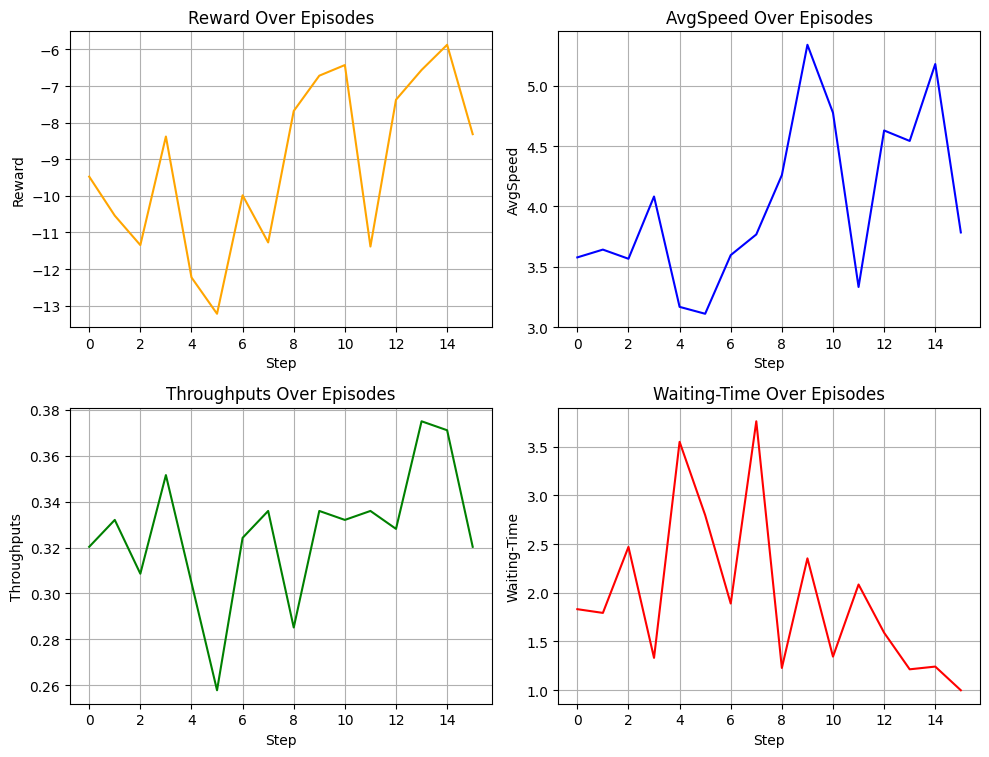

In [8]:
train_params = {
    "model":ppo_model,
    "env": env

}

model_hist = train_ppo(**train_params)